In [1]:
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from pymer4.models import Lmer
from pymer4.stats import rsquared, rsquared_adj
import re
import rpy2

# import rpy2.rinterface as rinterface
# rinterface.initr()

In [2]:
os.environ['LD_LIBRARY_PATH'] = '/mnt/c/Users/Erika.Peirce/AppData/Local/Programs/R/R-4.2.3/library'

In [3]:
inPATH = '../data/training/iapar/cper_biomass_iapar_2014_2022.csv'
inPATH_grazing = '../data/ground/grazing/CARM_ActualGrazingInfov3_2013-2023.csv'

In [4]:
df = pd.read_csv(inPATH, parse_dates=True)
df_grazing = pd.read_csv(inPATH_grazing)

In [5]:
df_grazing[df_grazing['PastureCode'] == 'NH'] = '10S'

In [6]:
df = df.dropna(subset=['Date', 'Total_Biomass', 'iAPAR']).copy().reset_index()

In [7]:
df_grazing_in = pd.merge(df, df_grazing[['PastureCode', 'Year', 'DateInPasture']],
         left_on=['Pasture', 'Year'],
         right_on=['PastureCode', 'Year'],
         how='left')

In [8]:
df_grazing_in = df_grazing_in.set_index('index')

In [9]:
df = df.set_index('index')

In [10]:
df['DateInPasture'] = df_grazing_in.drop_duplicates(subset=['Id', 'Year'], keep='first')['DateInPasture']

In [11]:
df['DateInPasture'] = pd.to_datetime(df['DateInPasture'])

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [46]:
df

,Year,Pasture,Plot,Id,Treatment,Block,Ecosite,AG,BOBU,C3PG,...,WSPG,SS,OTHER,NA,Total_Biomass,Date,iAPAR,DateInPasture,Graze_timing,Total_Biomass_sqrt
index,,,,,,,,,,,,,,,,,,,,,
92,2014,10S,1,10S_P1,AGM,1,Loamy,564.4325,222.0050,201.5550,...,186.0800,111.9450,0.0,0.0,2021.4625,2014-08-04,123.495323,NaT,Ungrazed,44.960677
93,2014,10S,2,10S_P2,AGM,1,Loamy,235.5950,803.1250,31.2150,...,6.1900,0.0000,0.0,0.0,1398.7725,2014-08-04,152.910320,NaT,Ungrazed,37.400167
94,2014,10S,3,10S_P3,AGM,1,Loamy,8.8800,694.6775,250.1275,...,0.0000,0.0000,0.0,0.0,1098.5925,2014-08-04,164.764037,NaT,Ungrazed,33.145022
95,2014,10S,4,10S_P4,AGM,1,Loamy,390.3250,460.4250,16.1475,...,0.0000,0.0000,0.0,0.0,1551.7525,2014-08-04,159.652053,NaT,Ungrazed,39.392290
96,2014,15E,1,15E_P1,TGM,1,Loamy,571.7000,511.4225,35.5200,...,4.5750,85.9775,0.0,0.0,1163.8500,2014-08-04,103.124891,2014-05-15,Pulse,34.115246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,2022,7SE,6,7SE_P6,AGM,7,Salt Flats,0.0000,15.6075,164.8650,...,74.4575,126.3550,0.0,0.0,380.5325,2022-08-04,44.869000,2022-07-21,Ungrazed,19.507242
988,2022,8E,1,8E_P1,AGM,8,Loamy,0.0000,110.9900,94.2650,...,0.0000,0.0000,0.0,0.0,239.0125,2022-08-03,35.033633,NaT,Ungrazed,15.460029
989,2022,8E,2,8E_P2,AGM,8,Sandy,0.0000,216.7200,44.5500,...,5.6100,0.0000,0.0,0.0,313.2200,2022-08-03,28.615596,NaT,Ungrazed,17.698022


In [13]:
def calc_graze_timing(x):
    if pd.isnull(x['DateInPasture']):
        if x['Treatment'] in ['TGM', 'NEW_HVY']:
            timing = 'Season-long'
        else:
            timing = 'Ungrazed'
    elif x['DateInPasture'] > x['Date']:
        timing = 'Ungrazed'
    elif x['DateInPasture'].dayofyear > 196:
        timing = 'Ungrazed'
    elif x['DateInPasture'].dayofyear <= 196:
        timing = 'Pulse'
    return timing
        

In [14]:
df['Graze_timing'] = df.apply(lambda x: calc_graze_timing(x), axis=1)

In [15]:
df["Total_Biomass_sqrt"] = np.sqrt(df['Total_Biomass'])
df['Block'] = df['Block'].astype(int).astype(str)

In [16]:
df['Ecosite'] = pd.Categorical(df['Ecosite'],
                               categories=['Loamy', 'Sandy', 'Salt Flats'])
df['Graze_timing'] = pd.Categorical(df['Graze_timing'],
                               categories=['Ungrazed', 'Season-long', 'Pulse'])

In [17]:
df_sub = df[df['Treatment'].isin(['TGM', 'AGM'])].copy()

<Figure size 432x288 with 0 Axes>

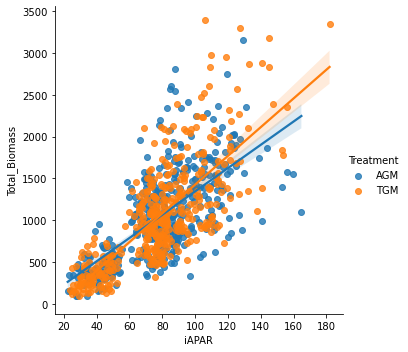

In [18]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Treatment', ci=95, 
           data=df_sub)
plt.show()

In [52]:
df_sub.to_csv('../data/training/iapar/model_selection_data.csv', index=False)

<Figure size 432x288 with 0 Axes>

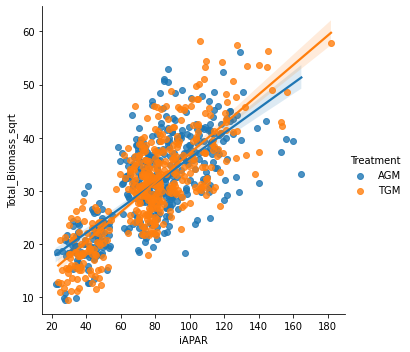

In [19]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

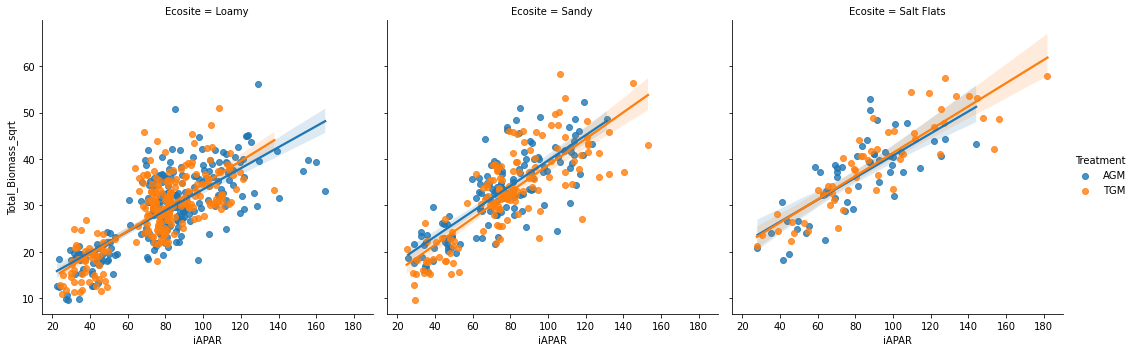

In [20]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', col='Ecosite', ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

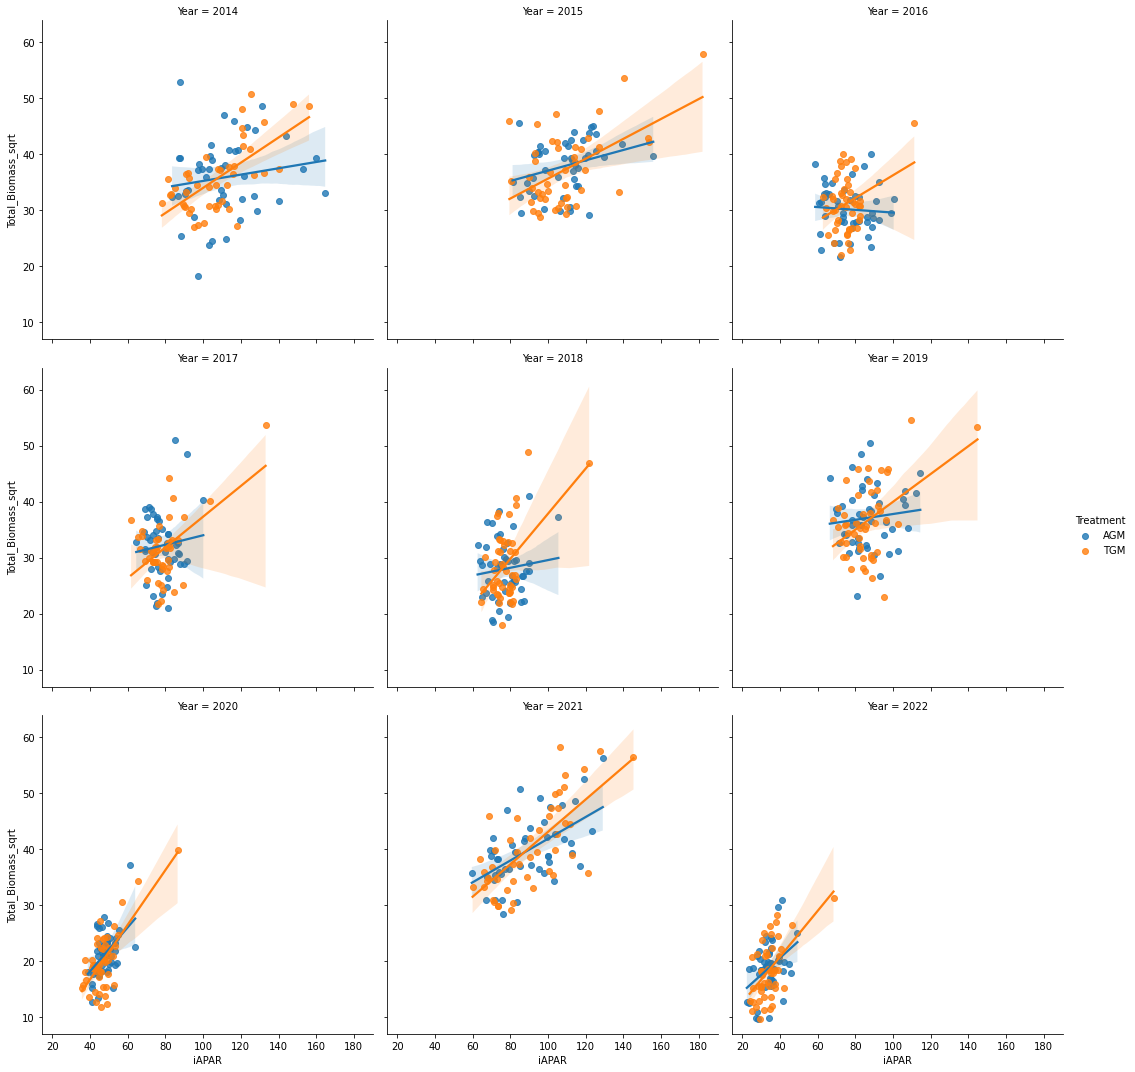

In [21]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', col='Year', col_wrap=3, ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

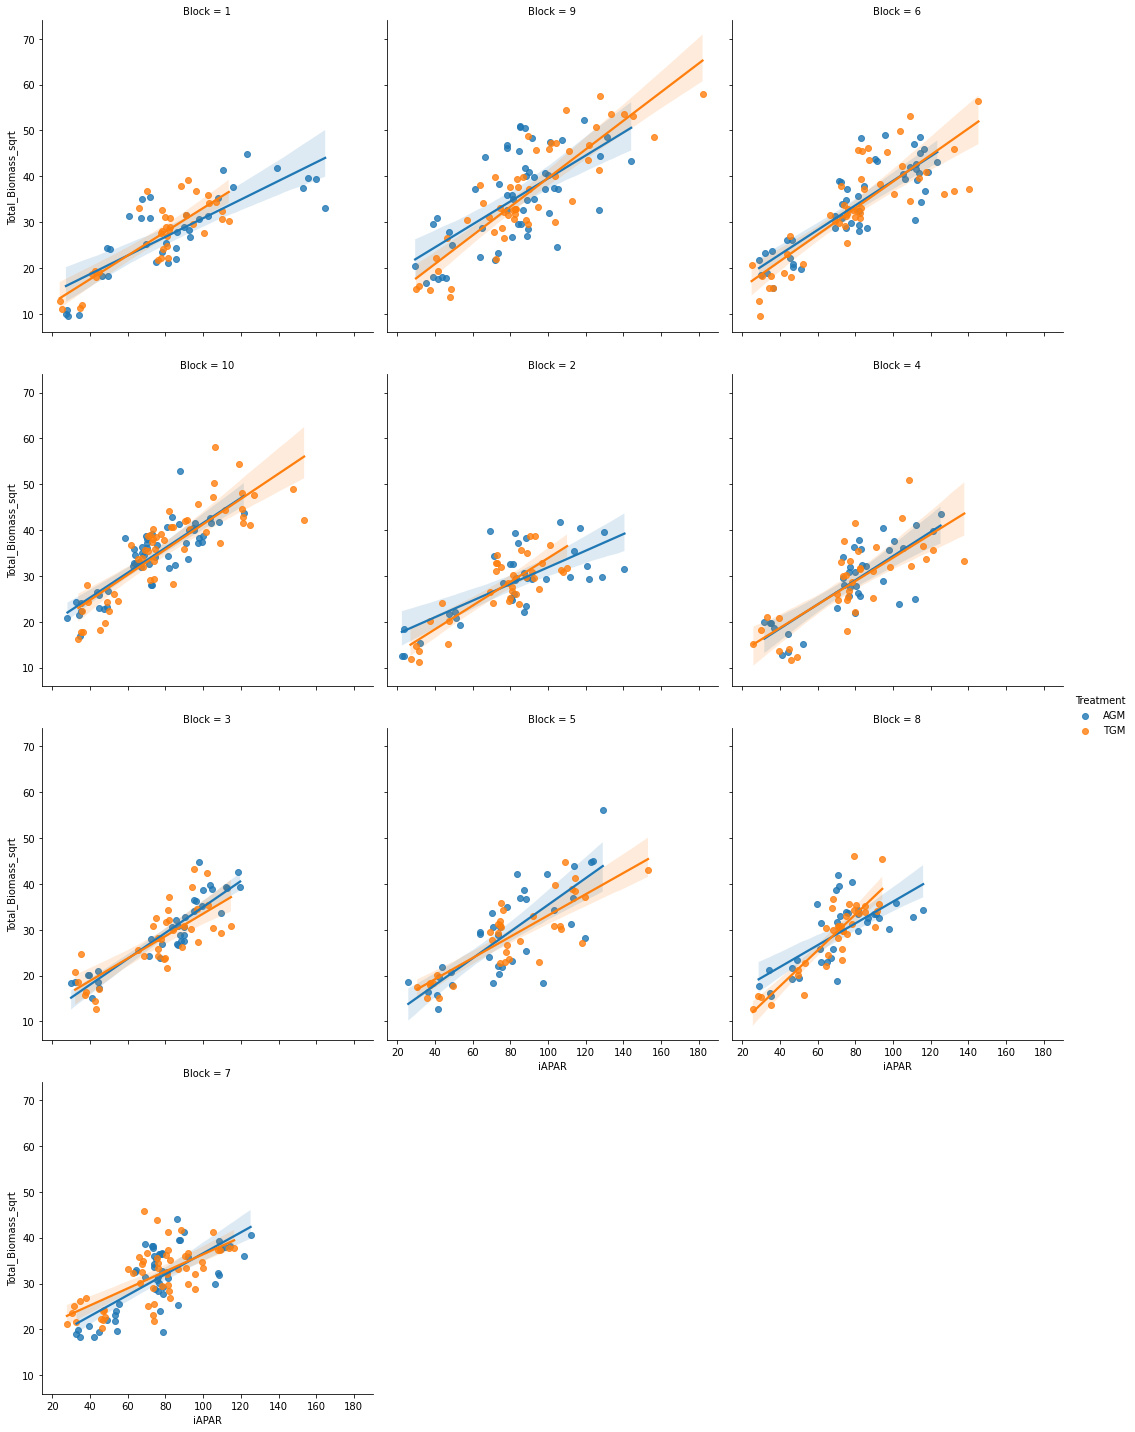

In [22]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', col='Block', col_wrap=3, ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

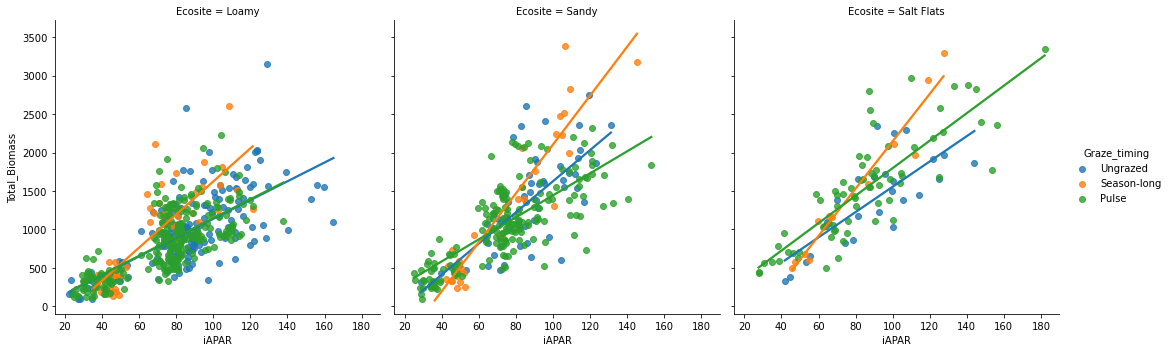

In [23]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Graze_timing', col='Ecosite', ci=None, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

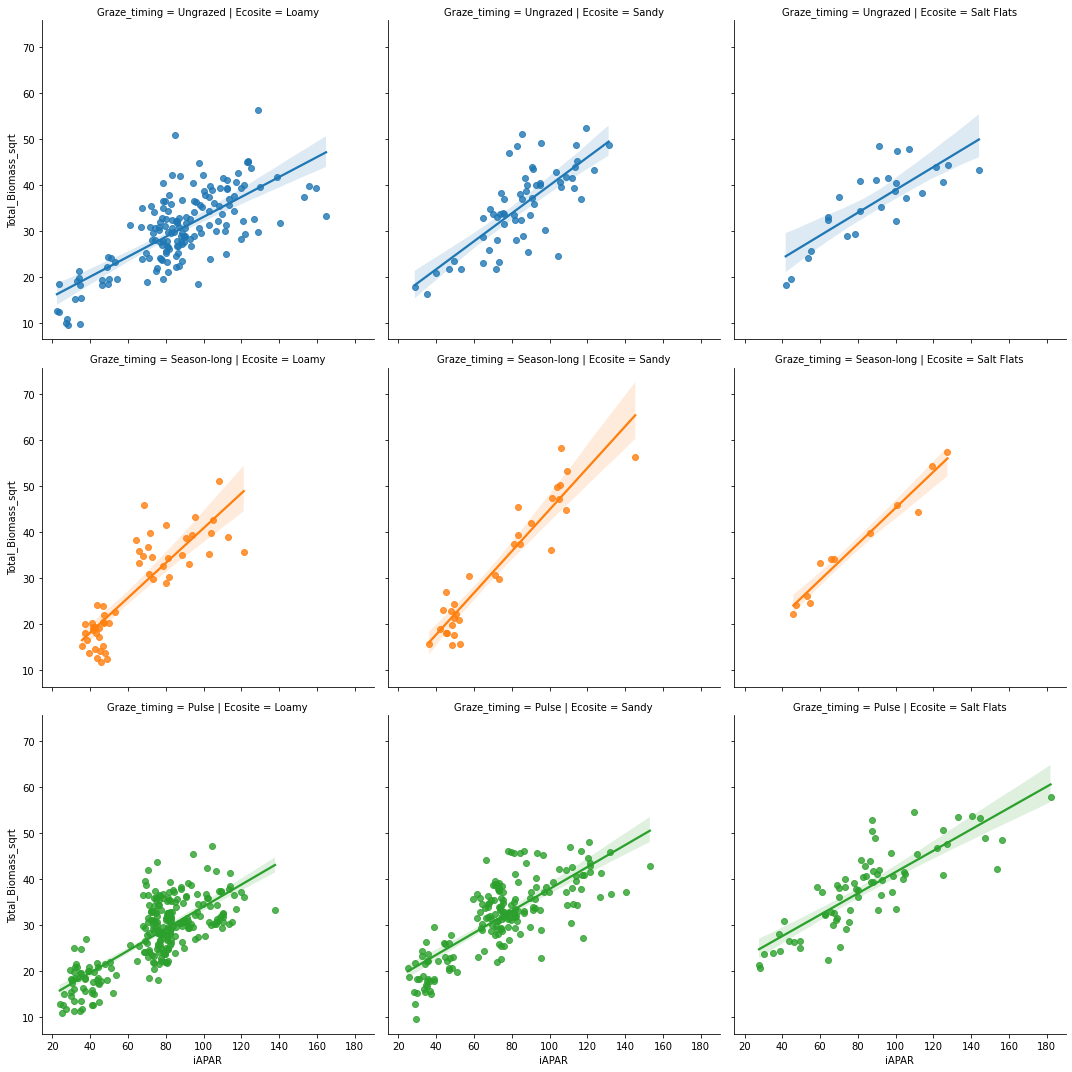

In [24]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Graze_timing', col='Ecosite', row='Graze_timing', ci=95, 
           data=df_sub)
plt.show()

In [25]:
# fit the null model, single slope for iAPAR
# NOTE: tried adding + (1|Block:Pasture) to account for pasture effect, but fit was singular and effect was 0
md_mm_orig = Lmer('Total_Biomass ~ iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_orig.fit())

md_mm_sqrt = Lmer('Total_Biomass_sqrt ~ iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_sqrt.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6154.010 	 AIC: 12318.021

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  43744.979  209.153
Year        (Intercept)  37028.078  192.427
Residual                 91447.762  302.403

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-49.559,-245.67,146.551,100.058,28.456,-0.495,0.624,
iAPAR,13.678,11.86,15.497,0.928,435.994,14.744,0.000,***


Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass_sqrt~iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -2536.228 	 AIC: 5082.455

Random effects:

                   Name     Var    Std
Year:Block  (Intercept)  10.424  3.229
Year        (Intercept)  14.029  3.746
Residual                 18.001  4.243

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),16.817,13.534,20.100,1.675,19.263,10.041,0.0,***
iAPAR,0.177,0.150,0.203,0.013,660.113,13.168,0.0,***


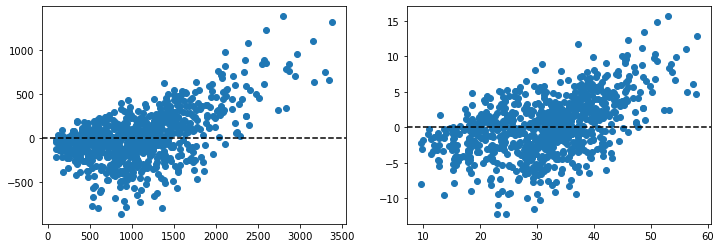

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].scatter(df_sub['Total_Biomass'], md_mm_orig.residuals)
axs[1].scatter(df_sub['Total_Biomass_sqrt'], md_mm_sqrt.residuals)
for ax in axs:
    ax.axhline(y=0, linestyle='dashed', c='black')

(array([  8.,  25.,  99., 201., 257., 151.,  76.,  25.,   6.,   4.]),
 array([-12.2179861 ,  -9.43346595,  -6.64894579,  -3.86442564,
         -1.07990549,   1.70461467,   4.48913482,   7.27365497,
         10.05817513,  12.84269528,  15.62721543]),
 <BarContainer object of 10 artists>)

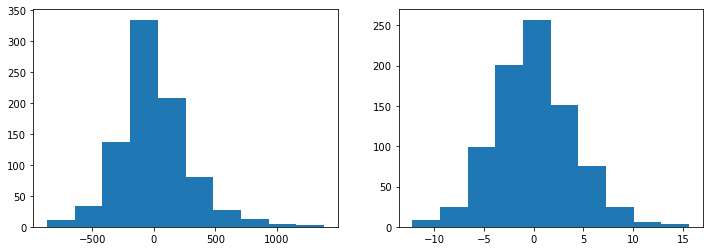

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].hist(md_mm_orig.residuals)
axs[1].hist(md_mm_sqrt.residuals)

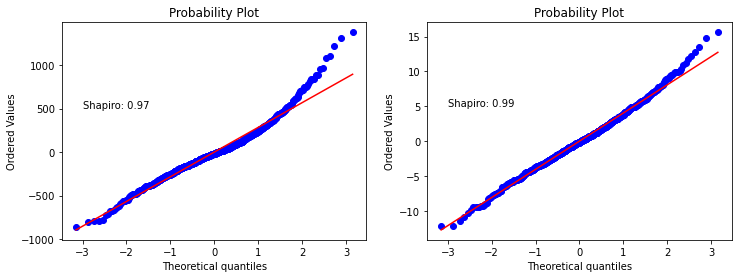

In [28]:
from scipy.stats import shapiro, probplot
import pylab


fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
probplot(md_mm_orig.residuals, dist="norm", plot=axs[0])
axs[0].text(-3, 500, 'Shapiro: ' + str(round(shapiro(md_mm_orig.residuals).statistic, 2)))
probplot(md_mm_sqrt.residuals, dist="norm", plot=axs[1])
axs[1].text(-3, 5, 'Shapiro: ' + str(round(shapiro(md_mm_sqrt.residuals).statistic, 2)))
plt.show()

In [29]:
y_var = 'Total_Biomass'
#axlims = (-0.25, 0.25)
axlims = (-5, 16)

In [30]:
# fit the null model, single slope for iAPAR
# NOTE: tried adding + (1|Block:Pasture) to account for pasture effect, but fit was singular and effect was 0
md_mm_null = Lmer(y_var + ' ~ iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_null.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6154.010 	 AIC: 12318.021

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  43744.979  209.153
Year        (Intercept)  37028.078  192.427
Residual                 91447.762  302.403

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-49.559,-245.67,146.551,100.058,28.456,-0.495,0.624,
iAPAR,13.678,11.86,15.497,0.928,435.994,14.744,0.000,***


Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Treatment:iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6153.754 	 AIC: 12319.508

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  43571.777  208.739
Year        (Intercept)  36995.508  192.342
Residual                 91427.632  302.370

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-50.169,-246.198,145.859,100.016,28.469,-0.502,0.62,
iAPAR,13.537,11.704,15.369,0.935,443.735,14.478,0.00,***
iAPAR:TreatmentTGM,0.301,-0.190,0.793,0.251,763.257,1.201,0.23,


<AxesSubplot:xlabel='Estimate'>

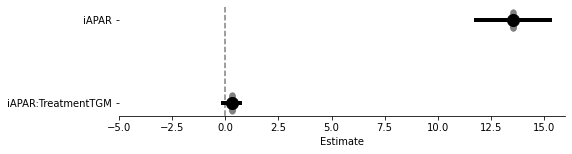

In [31]:
md_mm_treatment_int = Lmer(y_var + ' ~ iAPAR + Treatment:iAPAR  + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_treatment_int.fit())
md_mm_treatment_int.plot_summary(plot_intercept=False, figsize=(8, 2), axlim=axlims)

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Treatment+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6149.951 	 AIC: 12311.903

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  43733.385  209.125
Year        (Intercept)  37004.226  192.365
Residual                 91542.724  302.560

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-55.206,-252.751,142.338,100.790,29.256,-0.548,0.588,
iAPAR,13.689,11.869,15.508,0.928,434.918,14.745,0.000,***
TreatmentTGM,9.653,-30.990,50.297,20.737,762.399,0.466,0.642,


<AxesSubplot:xlabel='Estimate'>

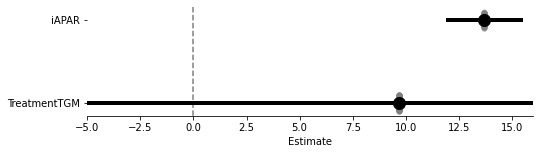

In [32]:
md_mm_treatment = Lmer(y_var + ' ~ iAPAR + Treatment + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_treatment.fit())
md_mm_treatment.plot_summary(plot_intercept=False, figsize=(8, 2), axlim=axlims)

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Graze_timing+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6141.294 	 AIC: 12296.587

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  41644.503  204.070
Year        (Intercept)  37845.315  194.539
Residual                 91160.027  301.927

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-134.872,-340.495,70.752,104.912,32.884,-1.286,0.208,
iAPAR,14.110,12.270,15.951,0.939,437.680,15.030,0.000,***
Graze_timingSeason-long,60.478,-28.667,149.624,45.483,778.448,1.330,0.184,
Graze_timingPulse,75.977,21.161,130.793,27.968,838.121,2.717,0.007,**


<AxesSubplot:xlabel='Estimate'>

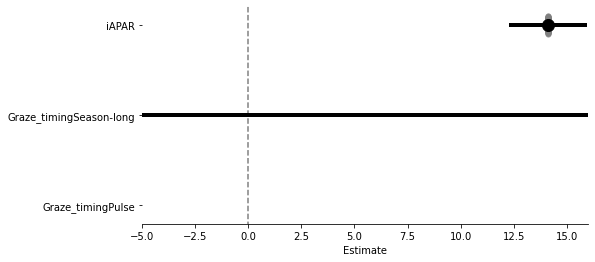

In [33]:
md_mm_graze= Lmer(y_var + ' ~ iAPAR + Graze_timing + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_graze.fit())
md_mm_graze.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

In [34]:
md_mm_graze_int = Lmer(y_var + ' ~ iAPAR + Graze_timing:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
# display(md_mm_graze.fit())
# md_mm_graze.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

In [35]:
md_mm_ecosite_int = Lmer(y_var + ' ~ iAPAR + Ecosite:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
# display(md_mm_ecosite_int.fit())
# md_mm_ecosite_int.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Ecosite+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6090.651 	 AIC: 12195.301

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  17375.144  131.815
Year        (Intercept)  45977.968  214.425
Residual                 85432.346  292.288

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-15.449,-215.323,184.425,101.978,24.692,-0.151,0.881,
iAPAR,11.977,10.218,13.736,0.898,502.168,13.345,0.000,***
EcositeSandy,195.290,139.513,251.068,28.459,474.674,6.862,0.000,***
EcositeSalt Flats,416.895,345.243,488.547,36.558,760.069,11.404,0.000,***


<AxesSubplot:xlabel='Estimate'>

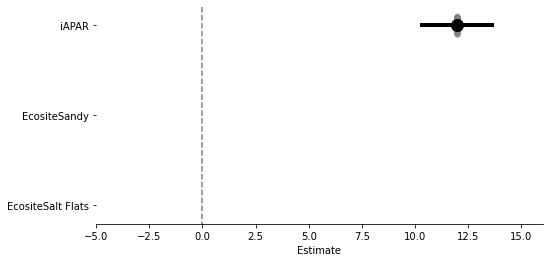

In [54]:
md_mm_ecosite= Lmer(y_var + ' ~ iAPAR + Ecosite + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_ecosite.fit())
md_mm_ecosite.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

In [37]:
md_mm_treatment_ecosite = Lmer(y_var + ' ~ iAPAR + Treatment:iAPAR + Ecosite:iAPAR + Treatment:Ecosite:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
# display(md_mm_treatment_ecosite.fit())
# md_mm_treatment_ecosite.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

In [38]:
md_mm_graze_ecosite = Lmer(y_var + ' ~ iAPAR + Graze_timing + Ecosite + Graze_timing:Ecosite:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
# display(md_mm_graze_ecosite.fit())
# md_mm_graze_ecosite.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

In [39]:
md_mm_graze_ecosite_int = Lmer(y_var + ' ~ iAPAR + Graze_timing:iAPAR + Ecosite:iAPAR + Graze_timing:Ecosite:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
# display(md_mm_graze_ecosite.fit())
# md_mm_graze_ecosite.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

In [40]:
mod_dict = {
    'Null': {
        'model': md_mm_null},
    'CARM': {
        'model': md_mm_treatment},
    'Grazing': {
        'model': md_mm_graze},
    'Ecosite': {
        'model': md_mm_ecosite},
    'CARM + Ecosite': {
        'model': md_mm_treatment_ecosite},
    'Grazing + Ecosite': {
        'model': md_mm_graze_ecosite},
}

In [42]:
for mod in mod_dict:
    r2 = rsquared(mod_dict[mod]['model'].data[y_var], mod_dict[mod]['model'].residuals, has_constant=True)
    r2_adj = rsquared_adj(r2, nobs=len(mod_dict[mod]['model'].residuals), 
                          df_res=(len(mod_dict[mod]['model'].residuals) - len(mod_dict[mod]['model'].coefs)),
                          has_constant=True)
    mod_dict[mod]['R2_adj'] = r2_adj
    mod_dict[mod]['AIC'] = mod_dict[mod]['model'].AIC

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [ ]:
mod_dict[mod]['model'].formula

In [ ]:
df_results = pd.DataFrame({'Model': [k for k in mod_dict.keys()],
                           'AIC': [mod_dict[k]['AIC'] for k in mod_dict.keys()],
                           'R2': [mod_dict[k]['R2_adj'] for k in mod_dict.keys()]})

In [ ]:
df_results['AICd'] = df_results['AIC'] - df_results['AIC'].min()

In [ ]:
df_results['AICw'] = np.exp( -0.5 * df_results['AICd'])

In [ ]:
df_results['formula'] = df_results['Model'].transform(lambda x: mod_dict[x]['model'].formula)

In [ ]:
with pd.option_context('display.max_colwidth', 500):
    display(df_results.sort_values('AICd'))

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].scatter(df_sub['Total_Biomass'], md_mm_graze_ecosite.residuals)
#axs[1].scatter(df_sub['Total_Biomass_sqrt'], md_mm_sqrt.residuals)
for ax in axs:
    ax.axhline(y=0, linestyle='dashed', c='black')

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].hist(md_mm_ecosite.residuals)
axs[1].hist(md_mm_sqrt.residuals)

In [ ]:

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
probplot(md_mm_ecosite.residuals, dist="norm", plot=axs[0])
axs[0].text(-3, 500, 'Shapiro: ' + str(round(shapiro(md_mm_ecosite.residuals).statistic, 2)))
probplot(md_mm_sqrt.residuals, dist="norm", plot=axs[1])
axs[1].text(-3, 5, 'Shapiro: ' + str(round(shapiro(md_mm_sqrt.residuals).statistic, 2)))
plt.show()

In [ ]:
coefs_fnl = md_mm_graze_ecosite.coefs.reset_index().rename(columns={'index': 'Coef'})
coefs_fnl['Coef'] = coefs_fnl['Coef'].apply(lambda x: re.sub('Ecosite', '', 
                                         re.sub('Graze_timing', '', x)))
coefs_fnl = coefs_fnl[coefs_fnl['Coef'] != '(Intercept)']
colors = coefs_fnl.apply(lambda x: 'grey' if x['Sig'] == '' else 'black', axis=1).astype(str).values

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
col_lb = (coefs_fnl["Estimate"] - coefs_fnl["2.5_ci"]).values
col_ub = (coefs_fnl["97.5_ci"] - coefs_fnl["Estimate"]).values

x_strip = "Estimate"
x_err = coefs_fnl["Estimate"]
y_strip = "Coef"
y_err = np.array([x for x in range(len(coefs_fnl))])
xerr = [col_lb, col_ub]
yerr = None
ax.vlines(
    x=0, ymin=-1, ymax=len(coefs_fnl), linestyles="--", color="grey"
)
xlim = (-5.0, 13)
ylim = None
sns.stripplot(
            x=x_strip, y=y_strip, data=coefs_fnl, ax=ax, size=6, alpha=0, color="grey"
        )
for c in np.unique(colors):
    ax.errorbar(
                x=x_err[colors == c],
                y=y_err[colors == c],
                xerr=[col_lb[colors == c], col_ub[colors == c]],
                yerr=yerr,
                fmt="o",
                capsize=0,
                elinewidth=4,
                color=c,
                ms=12,
                zorder=9999999999,
            )
    [ax.get_yticklabels()[i].set_color(c) for i, color in enumerate(colors) if color == c]
    #ax.get_yticklabels()[colors == c].set_color("red")
sns.despine(top=True, right=True, left=True)

In [ ]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Graze_timing', col='Ecosite', ci=None, 
           data=df_sub)
plt.show()

In [ ]:
df['pred_biomass'] = md_mm_graze_ecosite.predict(df, skip_data_checks=True, use_rfx=True, verify_predictions=False)
df['pred_biomass_no_rf'] = md_mm_graze_ecosite.predict(df, skip_data_checks=True, use_rfx=False, verify_predictions=False)
df['resid_biomass'] = df['Total_Biomass'] - df['pred_biomass']
df['resid_biomass_no_rf'] = df['Total_Biomass'] - df['pred_biomass_no_rf']

In [ ]:
p = sns.lmplot(x='Total_Biomass', y='pred_biomass', hue='Treatment', data=df,
            scatter_kws=dict(s=10))
p.ax.plot(np.arange(0, 3500), np.arange(0, 3500), c='black', linestyle='dashed')

In [ ]:
p = sns.lmplot(x='Total_Biomass', y='pred_biomass_no_rf', hue='Treatment', data=df,
            scatter_kws=dict(s=10))
p.ax.plot(np.arange(0, 3500), np.arange(0, 3500), c='black', linestyle='dashed')

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].scatter(df_sub['Total_Biomass'], df['resid_biomass'][df['Treatment'].isin(['AGM', 'TGM'])])
axs[1].scatter(df_sub['Total_Biomass'], df['resid_biomass_no_rf'][df['Treatment'].isin(['AGM', 'TGM'])])

In [ ]:
df_sub

In [44]:
# Define the candidate models
candidate_models = [
    f"{y_var} ~ iAPAR + (1|Year) + (1|Year:Block)",
    f"{y_var} ~ Graze_timing + (1|Year) + (1|Year:Block)",
    f"{y_var} ~ Ecosite + (1|Year) + (1|Year:Block)",
    # Add the rest of the candidate models
]

# Function to fit and evaluate each model using AIC
def fit_and_evaluate_model(formula):
    model = sm.MixedLM.from_formula(formula, data=df, groups=df["Year"])  # Assuming "Year" is the grouping variable
    result = model.fit()
    return result

# Fit and evaluate each model, storing AIC values
aic_values = {}
for formula in candidate_models:
    result = fit_and_evaluate_model(formula)
    aic_values[formula] = result.aic

# Find the model with the lowest AIC
best_model = min(aic_values, key=aic_values.get)
best_aic = aic_values[best_model]

print(f"Best model: {best_model}")
print(f"Best AIC: {best_aic}")

Best model: Total_Biomass ~ iAPAR + (1|Year) + (1|Year:Block)
Best AIC: nan


In [45]:
aic_values

{'Total_Biomass ~ iAPAR + (1|Year) + (1|Year:Block)': nan,
 'Total_Biomass ~ Graze_timing + (1|Year) + (1|Year:Block)': nan,
 'Total_Biomass ~ Ecosite + (1|Year) + (1|Year:Block)': nan}